# Hiding future words with causal attention

**Descrição**  
Nesta parte, implementamos uma variação de *self-attention* chamada **causal attention**.  
Ela é usada em modelos autoregressivos (como GPT) para garantir que, ao prever o próximo token, o modelo **não tenha acesso a tokens futuros** na sequência.

**Objetivo**  
- Construir uma camada de atenção que respeite a ordem temporal da sequência.  
- Impedir que cada token “olhe para frente” (posições à direita), evitando *data leakage* durante o treinamento.  
- Visualizar, via *heatmap*, como a máscara causal altera os pesos de atenção e como o dropout afeta esses pesos em `train()` vs `eval()`.

**Funcionamento**  
1. **Embeddings**: transformamos cada token em um vetor contínuo (embedding), gerando um tensor `x` com formato `(batch, T, d_in)`.  
2. **Projeções Q, K, V**: aplicamos camadas lineares para obter `queries (Q)`, `keys (K)` e `values (V)`.  
3. **Attention scores**: calculamos `Q @ Kᵀ`, produzindo uma matriz `(T, T)` de similaridades entre posições.  
4. **Máscara causal**: aplicamos uma matriz triangular superior (acima da diagonal) preenchendo essas posições com `-inf`, para que o softmax resulte em probabilidade ~0 para tokens futuros (`j > i`).  
5. **Softmax + scaling**: normalizamos os scores (com *scaling* por `sqrt(d_k)`) para obter os pesos de atenção.  
6. **Context vector**: combinamos os `values (V)` ponderados pelos pesos, resultando no vetor de contexto para cada posição.  
7. **Dropout**: em modo `train()`, o dropout “zera” parte dos pesos, alterando o padrão de atenção; em `eval()`, ele é desativado, tornando o resultado determinístico.

![O gato sobe no tapete](../../imagens/cap03/03_gato_sobe_no_tapete.png)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Para reprodutibilidade
torch.manual_seed(42)

## Tokenização simples e vocabulário

In [2]:
# Frase de exemplo
sentence = "O gato sobe no tapete"

# Tokenização simples (já pré-processada)
tokens = sentence.split()

# Construção do vocabulário
vocab = {token: idx for idx, token in enumerate(tokens)}
inv_vocab = {idx: token for token, idx in vocab.items()}

vocab, inv_vocab

({'O': 0, 'gato': 1, 'sobe': 2, 'no': 3, 'tapete': 4},
 {0: 'O', 1: 'gato', 2: 'sobe', 3: 'no', 4: 'tapete'})

## Conversão para token IDs

In [3]:
# Convertendo tokens para IDs
token_ids = torch.tensor([vocab[token] for token in tokens])

token_ids

tensor([0, 1, 2, 3, 4])

## Camada de Embedding

Vamos usar uma dimensão pequena (**3**) para facilitar a visualização dos vetores.

In [4]:
# Dimensão do embedding (pequena para visualização)
embedding_dim = 3

# Camada de embedding
embedding_layer = torch.nn.Embedding(
    num_embeddings=len(vocab), embedding_dim=embedding_dim
)

# Obtendo os embeddings
embeddings = embedding_layer(token_ids)

embeddings

tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890]], grad_fn=<EmbeddingBackward0>)

## Preparando o batch (dimensão de batch)

A implementação do autor espera `x` no formato:

- `(b, num_tokens, d_in)`

Aqui vamos usar `b=1` (um único exemplo).

In [5]:
# (num_tokens, d_in) -> (b, num_tokens, d_in)
x = embeddings.unsqueeze(0)

# Context length (tamanho máximo de contexto suportado pela máscara)
context_length = len(tokens)

x.shape, context_length

(torch.Size([1, 5, 3]), 5)

## CausalAttention (código do autor)

Pontos importantes:
- `mask = torch.triu(..., diagonal=1)` cria a máscara triangular superior;
- `masked_fill_(..., -inf)` anula (após o softmax) a atenção para posições futuras.

In [6]:
class CausalAttention(nn.Module):
    """
    Implementa atenção causal (single-head) com máscara triangular superior
    para impedir que cada token "veja" tokens futuros.

    Parâmetros:
    ----------
    d_in : int
        Dimensão de entrada (embedding/hidden size de entrada).
    d_out : int
        Dimensão de saída (embedding/hidden size após projeções Q, K, V).
    context_length : int
        Comprimento máximo de contexto (número máximo de tokens).
    dropout : float
        Probabilidade de dropout aplicada aos pesos de atenção.
    qkv_bias : bool, default = False
        Se True, adiciona bias nas camadas lineares de Q, K e V.

    Retorno:
    -------
    torch.Tensor
        Tensor de forma (batch_size, num_tokens, d_out) contendo os vetores de contexto.

    Exceções:
    --------
    Levanta ValueError se o input não for 3D (B, T, D) ou se d_in não bater com o
    último eixo do input.
    """

    def __init__(
        self,
        d_in: int,
        d_out: int,
        context_length: int,
        dropout: float,
        qkv_bias: bool = False,
    ) -> None:
        super().__init__()
        self.d_out = int(d_out)

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)

        # Máscara causal: 1s acima da diagonal principal (tokens futuros).
        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim != 3:
            raise ValueError(
                f"Esperado x com 3 dimensões (batch, tokens, d_in), mas veio shape={tuple(x.shape)}."
            )

        b, num_tokens, d_in = x.shape

        # Projeções lineares
        keys = self.W_key(x)  # (b, T, d_out)
        queries = self.W_query(x)  # (b, T, d_out)
        values = self.W_value(x)  # (b, T, d_out)

        # Scores de atenção: (b, T, d_out) @ (b, d_out, T) -> (b, T, T)
        attn_scores = queries @ keys.transpose(1, 2)

        # Aplicar máscara causal (in-place)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        # Softmax com escala por sqrt(d_k)
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

        attn_weights = self.dropout(attn_weights)

        # Vetor de contexto: (b, T, T) @ (b, T, d_out) -> (b, T, d_out)
        context_vec = attn_weights @ values
        return context_vec

## Aplicando a CausalAttention

Vamos começar com `dropout=0.0` para facilitar inspeção (sem aleatoriedade extra).

In [7]:
causal_attn = CausalAttention(
    d_in=embedding_dim,
    d_out=3,
    context_length=context_length,
    dropout=0.0,
    qkv_bias=False,
)

context_vec = causal_attn(x)
context_vec

tensor([[[-0.3250,  0.2370,  0.1661],
         [-0.0674,  0.0612,  0.0697],
         [-0.6145,  0.4905,  0.3077],
         [-0.5704,  0.4352,  0.3115],
         [-0.4064,  0.3249,  0.2119]]], grad_fn=<UnsafeViewBackward0>)

## Inspecionando máscara e pesos de atenção

A classe retorna apenas `context_vec`. Para visualizar:
- `mask`
- `attn_scores` (com máscara)
- `attn_weights`

vamos reproduzir o miolo do `forward` usando os mesmos pesos (`W_query`, `W_key`, `W_value`).

In [8]:
# Reproduzindo o forward para inspecionar scores/pesos
with torch.no_grad():
    keys = causal_attn.W_key(x)
    queries = causal_attn.W_query(x)
    values = causal_attn.W_value(x)

    attn_scores = queries @ keys.transpose(1, 2)  # (b, T, T)

    # Máscara efetiva (recortada para num_tokens)
    effective_mask = causal_attn.mask.bool()[:context_length, :context_length]

    # Aplica máscara: bloqueia futuro com -inf
    masked_scores = attn_scores.clone()
    masked_scores.masked_fill_(effective_mask, -torch.inf)

    # Softmax (com scaling)
    attn_weights = torch.softmax(masked_scores / (keys.shape[-1] ** 0.5), dim=-1)

effective_mask, attn_weights

(tensor([[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False, False,  True],
         [False, False, False, False, False]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5106, 0.4894, 0.0000, 0.0000, 0.0000],
          [0.3175, 0.2573, 0.4252, 0.0000, 0.0000],
          [0.2297, 0.2369, 0.2986, 0.2348, 0.0000],
          [0.2279, 0.1869, 0.1802, 0.2522, 0.1529]]]))

### Checagem rápida: triângulo superior deve ser ~0

Se a máscara está correta, então `attn_weights[i, j]` deve ser **0** quando `j > i`.

In [9]:
# Pegando só a matriz (T, T) do único batch
W = attn_weights[0]

# Seleciona triângulo superior (acima da diagonal)
upper = torch.triu(W, diagonal=1)

upper, upper.max()

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]),
 tensor(0.))

### Print amigável: para onde cada token pode olhar

Cada token na posição `i` só pode atender para posições `<= i`.

In [10]:
W = attn_weights[0]  # (T, T)

for i, tok in enumerate(tokens):
    weights_row = W[i].tolist()
    visible = [
        (tokens[j], round(weights_row[j], 4)) for j in range(len(tokens)) if j <= i
    ]
    blocked = [
        (tokens[j], round(weights_row[j], 4)) for j in range(len(tokens)) if j > i
    ]
    print(f"[i={i:02d}] token='{tok}'")
    print("  visível (<= i):", visible)
    print("  futuro  (> i):", blocked)
    print()

[i=00] token='O'
  visível (<= i): [('O', 1.0)]
  futuro  (> i): [('gato', 0.0), ('sobe', 0.0), ('no', 0.0), ('tapete', 0.0)]

[i=01] token='gato'
  visível (<= i): [('O', 0.5106), ('gato', 0.4894)]
  futuro  (> i): [('sobe', 0.0), ('no', 0.0), ('tapete', 0.0)]

[i=02] token='sobe'
  visível (<= i): [('O', 0.3175), ('gato', 0.2573), ('sobe', 0.4252)]
  futuro  (> i): [('no', 0.0), ('tapete', 0.0)]

[i=03] token='no'
  visível (<= i): [('O', 0.2297), ('gato', 0.2369), ('sobe', 0.2986), ('no', 0.2348)]
  futuro  (> i): [('tapete', 0.0)]

[i=04] token='tapete'
  visível (<= i): [('O', 0.2279), ('gato', 0.1869), ('sobe', 0.1802), ('no', 0.2522), ('tapete', 0.1529)]
  futuro  (> i): []



### Visualização (heatmap) da máscara e da atenção

1) Primeiro, visualizamos a **máscara causal**  
2) Depois, visualizamos a matriz de **pesos de atenção** (após softmax)

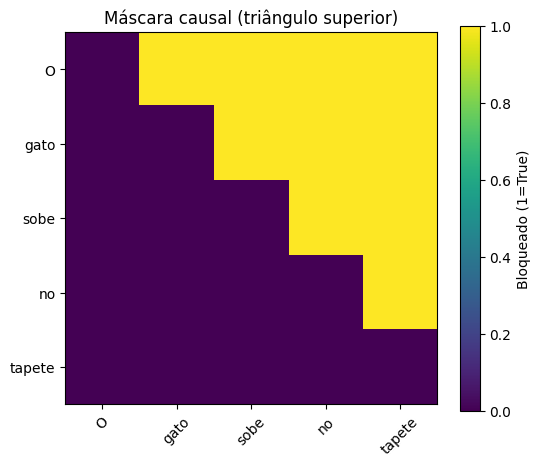

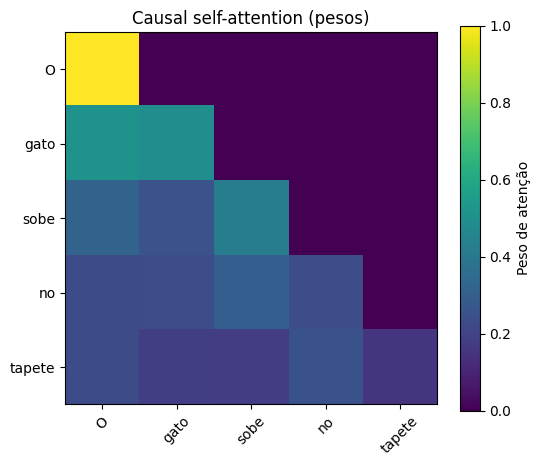

In [11]:
# 1) Máscara causal (True = bloqueado)
mask_np = effective_mask.cpu().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(mask_np)
plt.colorbar(label="Bloqueado (1=True)")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.title("Máscara causal (triângulo superior)")
plt.show()

# 2) Pesos de atenção (após softmax)
W_np = W.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(W_np)
plt.colorbar(label="Peso de atenção")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.title("Causal self-attention (pesos)")
plt.show()

## Efeito do dropout na atenção

- Em `train()`, o dropout é aplicado (pode zerar algumas probabilidades).
- Em `eval()`, o dropout não atua.

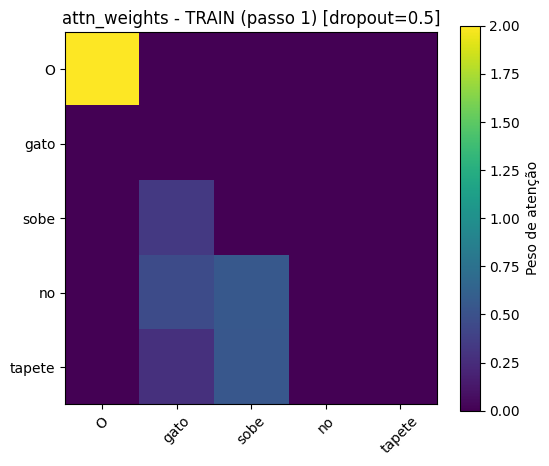

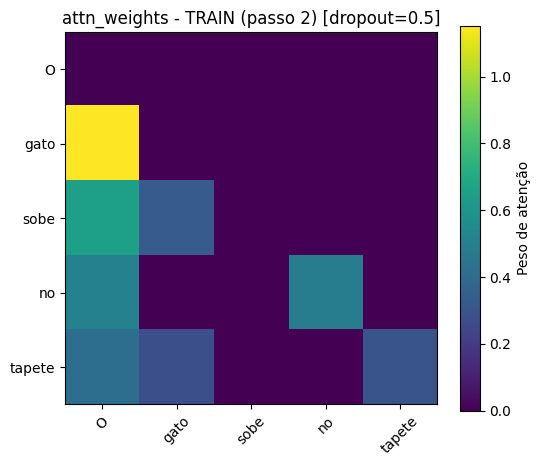

Diferença máxima (TRAIN): 2.0


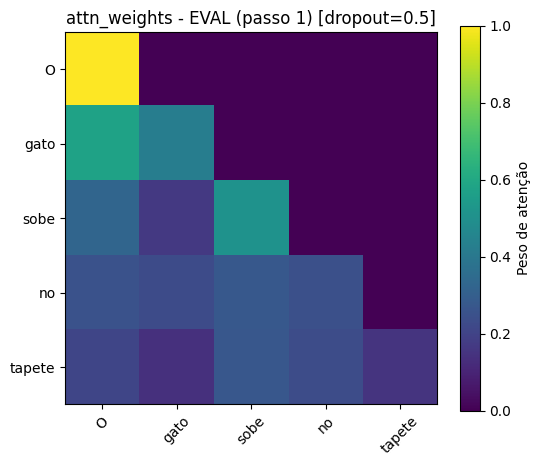

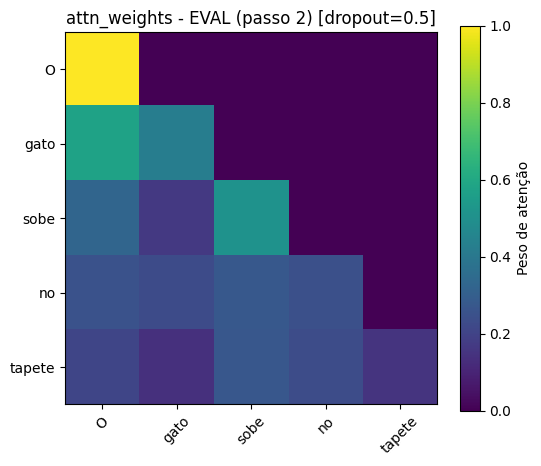

Diferença máxima (EVAL): 0.0


In [12]:
def get_attn_weights(module: nn.Module, x: torch.Tensor) -> torch.Tensor:
    """
    Reproduz o miolo do forward para extrair attn_weights,
    respeitando o estado do módulo (train/eval) e o dropout.

    Retorna: attn_weights com shape (b, T, T)
    """
    b, T, _ = x.shape
    keys = module.W_key(x)
    queries = module.W_query(x)

    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores = attn_scores.masked_fill(module.mask.bool()[:T, :T], -torch.inf)

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
    attn_weights = module.dropout(attn_weights)  # <- aqui entra o efeito do dropout
    return attn_weights


def plot_heatmap(mat: torch.Tensor, tokens, title: str):
    """
    Plota um heatmap simples para uma matriz (T, T).
    """
    mat = mat.detach().cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(mat)
    plt.colorbar(label="Peso de atenção")
    plt.xticks(range(len(tokens)), tokens, rotation=45)
    plt.yticks(range(len(tokens)), tokens)
    plt.title(title)
    plt.show()


# --- Instanciando com dropout ---
causal_attn_drop = CausalAttention(
    d_in=embedding_dim, d_out=embedding_dim, context_length=context_length, dropout=0.5
)

# ===== TRAIN MODE (dropout ativo) =====
causal_attn_drop.train()
attn_train_1 = get_attn_weights(causal_attn_drop, x)[0]
attn_train_2 = get_attn_weights(causal_attn_drop, x)[0]

plot_heatmap(attn_train_1, tokens, "attn_weights - TRAIN (passo 1) [dropout=0.5]")
plot_heatmap(attn_train_2, tokens, "attn_weights - TRAIN (passo 2) [dropout=0.5]")

print("Diferença máxima (TRAIN):", (attn_train_1 - attn_train_2).abs().max().item())

# ===== EVAL MODE (dropout desativado) =====
causal_attn_drop.eval()
attn_eval_1 = get_attn_weights(causal_attn_drop, x)[0]
attn_eval_2 = get_attn_weights(causal_attn_drop, x)[0]

plot_heatmap(attn_eval_1, tokens, "attn_weights - EVAL (passo 1) [dropout=0.5]")
plot_heatmap(attn_eval_2, tokens, "attn_weights - EVAL (passo 2) [dropout=0.5]")

print("Diferença máxima (EVAL):", (attn_eval_1 - attn_eval_2).abs().max().item())